# Introduction

This notebook presents the construction of a predictive model, we begin an exploration in the quality of the data and the transformation of some of its variables to facilitate the exploration. Next, we start brief analytical models that allow us to infer the variables most related to the target variable. And finally, several solution models are proposed, using decision trees, random trees and neural networks.

## Challenge
In this dataset you have 3 different outputs:
    
- No readmission;
- A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
- A readmission in more than 30 days (this one is not so good as well the last one, however, the reason could be the state of the patient.

Your task is either to classify a patient-hospital outcome or to cluster them aiming at finding patterns that give a distinct insight.

To do so, we suggest you create a notebook, like Jupyter (if you use python) or a Rmarkdown report (in case you use R) and make it available for us, i.e. github.

### Hint to success in your quest:

Develop and stay clear of the data science process you'll perform over the dataset and highlight important aspects you might consider affordable to discuss over.

## Data Set Origin

https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

### Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

    *(1) It is an inpatient encounter (a hospital admission).
    *(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
    *(3) The length of stay was at least 1 day and at most 14 days.
    *(4) Laboratory tests were performed during the encounter.
    *(5) Medications were administered during the encounter.
    
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.



In [3]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [4]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [6]:
pd.options.display.float_format = '{:,.1f}'.format 

In [7]:
df_diabetic = pd.read_csv('diabetic_data.csv')
df_diabetic.shape

(101766, 50)

### Understanding NaNs
We explore the number of null variables

In [8]:
df_diabetic.isnull().sum().sum()

0

In [9]:
df_diabetic.sample(4).T

,65252,78555,93318,78087
encounter_id,181828518,240122298,333808166,238018710
patient_nbr,107173854,33234453,92438460,59587443
race,Caucasian,Caucasian,AfricanAmerican,Hispanic
gender,Male,Male,Female,Female
age,[60-70),[70-80),[50-60),[70-80)
weight,?,?,?,?
admission_type_id,1,1,1,1
discharge_disposition_id,1,22,1,1
admission_source_id,7,7,7,7
time_in_hospital,5,11,2,8


### Reformating "?" and "None" for null
Null variables are reformatted

In [10]:
df_diabetic = df_diabetic.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_diabetic = df_diabetic.applymap(lambda x: np.nan if (x=='?') | (x=='None') else x if isinstance(x, str) else x)
df_diabetic.isnull().sum().sort_values(ascending=False).head(10)

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
gender                   0
dtype: int64

In [11]:
df_diabetic.isnull().sum().sort_values(ascending=False).head(10)/df_diabetic.shape[0]*100

weight              96.9
max_glu_serum       94.7
A1Cresult           83.3
medical_specialty   49.1
payer_code          39.6
race                 2.2
diag_3               1.4
diag_2               0.4
diag_1               0.0
gender               0.0
dtype: float64

### There are 3 columns with near of ~90% of null data

In [12]:
df_diabetic['max_glu_serum'].value_counts()

Norm    2597
>200    1485
>300    1264
Name: max_glu_serum, dtype: int64

In [13]:
df_diabetic['weight'].value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

### Generate pandas profiling report to validate variables

In [14]:
do_profiling = True
if do_profiling:
    profile = ProfileReport(df_diabetic, title="Diabetics Profiling Report",
                            explorative=True,
                            correlations={"cramers": {"calculate": False}})
    profile.to_file('diabetic_report.html')

Pandas profiling generates a report HTML with basic information about DB missing values, unique values and so on.

In [16]:
ls

David_Torres.ipynb             diabetic_report.html  model_ohe.parquet
description.pdf                IDs_mapping.csv       tsne_results.parquet
df_diabetic_processed.parquet  logs.log
diabetic_data.csv              mlruns/


### Exploring other data sources
An additional database explains the 3 column categorical codes

In [17]:
df_IDs = {}
df_IDs['admission_type'] = pd.read_csv('IDs_mapping.csv',nrows=8)
df_IDs['discharge_disposition'] = pd.read_csv('IDs_mapping.csv',nrows=29,skiprows=10)
df_IDs['admission_source'] = pd.read_csv('IDs_mapping.csv',nrows=29,skiprows=42)

In [18]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [19]:
display_side_by_side(df_IDs['admission_type'],df_IDs['admission_source'],df_IDs['discharge_disposition'])

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
,admission_source_id,description
0,1,Physician Referral


In [20]:
df_IDs.keys()

dict_keys(['admission_type', 'discharge_disposition', 'admission_source'])

### The following columns will be considered as categories given the previous information

In [21]:
# numeric to categorical
col_categories=['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df_diabetic[col_categories] = df_diabetic[col_categories].apply(pd.Categorical)

In [22]:
col_categories=['encounter_id','patient_nbr']
df_diabetic[col_categories] = df_diabetic[col_categories].apply(pd.Categorical)

In [23]:
df_diabetic.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,"101,766.0","101,766.0","101,766.0","101,766.0","101,766.0","101,766.0","101,766.0","101,766.0"
mean,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4
std,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9
min,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
25%,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0
50%,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0
75%,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0
max,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0


In [24]:
df_describe_object =  df_diabetic.describe(include=[object,'category']).T
df_describe_object.T

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,99493,101766,101766,3197,101766,101766,101766,61510,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,101766,71518,5,3,10,9,8,26,17,17,...,1,4,4,2,2,2,2,2,2,3
top,443867222,88785891,Caucasian,Female,[70-80),[75-100),1,1,7,MC,...,No,No,No,No,No,No,No,No,Yes,NO
freq,1,40,76099,54708,26068,1336,53990,60234,57494,32439,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


### With help of the pandas profiling report we can delete and reorganization some columns. For example for gender column we can delete unknown class due it represents less than 0.1%

In [25]:
# Delete 0.1%
df_diabetic = df_diabetic[df_diabetic['gender'].isin(['Female', 'Male'])]
df_describe_object =  df_diabetic.describe(include=[object,'category']).T

### Some of the categories with less than 4 unique values could be processed into binary variables, and some ordinal categories can be reinterpreted as numeric.

In [26]:
df_describe_object[df_describe_object['unique'].isin([1,2,3,4])]

,count,unique,top,freq
gender,101763,2,Female,54708
max_glu_serum,5346,3,Norm,2597
A1Cresult,17018,3,>8,8216
metformin,101763,4,No,81776
repaglinide,101763,4,No,100224
nateglinide,101763,4,No,101060
chlorpropamide,101763,4,No,101677
glimepiride,101763,4,No,96572
acetohexamide,101763,2,No,101762
glipizide,101763,4,No,89078


In [27]:
df_diabetic['max_glu_serum'] = df_diabetic['max_glu_serum'].replace({'Norm':100,'>200':200,'>300':300})

<ipython-input-27-6e34a4dc4d3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['max_glu_serum'] = df_diabetic['max_glu_serum'].replace({'Norm':100,'>200':200,'>300':300})


In [28]:
df_diabetic['A1Cresult'] = df_diabetic['A1Cresult'].replace({'Norm':4,'>7':7,'>8':8})

<ipython-input-28-f76cc7ca8897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['A1Cresult'] = df_diabetic['A1Cresult'].replace({'Norm':4,'>7':7,'>8':8})


### For medicaments let's create two new columns changes over the dosage and if the person was using the medicament. Also, let's create a counter variable for the number of medications and changes in dosages.

In [29]:
# 'Up','Down' -> 'Yes' (indicates changes on dosage)
# 'Up','Down','Steady' -> 'Yes' (indicates drugs)

cols_med = ['metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide','citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']


df_diabetic['cnt_meds_change']=0
df_diabetic['cnt_meds']=0

for i in cols_med:
    df_diabetic[i+'_change'] = df_diabetic[i].isin(['Up','Down'])*1
    df_diabetic[i] = df_diabetic[i].isin(['Up','Down','Steady'])*1
    
    df_diabetic['cnt_meds_change'] = df_diabetic['cnt_meds'] + df_diabetic[i+'_change']
    df_diabetic['cnt_meds'] = df_diabetic['cnt_meds'] + df_diabetic[i] 

<ipython-input-29-253607db7d0a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['cnt_meds_change']=0
<ipython-input-29-253607db7d0a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diabetic['cnt_meds']=0
<ipython-input-29-253607db7d0a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [30]:
df_describe_object =  df_diabetic.describe(include=[object,'category']).T
cols_cat_2 = df_describe_object[df_describe_object['unique']==2].index
df_describe_object[df_describe_object['unique']==2]

,count,unique,top,freq
gender,101763,2,Female,54708
change,101763,2,No,54754
diabetesMed,101763,2,Yes,78361


In [31]:
df_diabetic[cols_cat_2].isnull().sum().sum()

0

In [32]:
df_diabetic = pd.concat([
    df_diabetic,
    pd.get_dummies(df_diabetic[cols_cat_2], drop_first=True)
],axis=1).drop(columns=cols_cat_2)

### Age and weight are interpreted as numeric variables

In [33]:
def interval_to_num(x):
    if isinstance(x, str):
        x_num = re.findall(r'\d+.*-', x)
        if len(x_num) > 0:
            return int(x_num[0][:-1])
        else:
            return int(re.findall(r'>.*\d', x)[0][1:])
    else:
        return np.nan 

In [34]:
display_side_by_side(df_diabetic['age'].value_counts().reset_index(), df_diabetic['weight'].value_counts().reset_index())

,index,age
0,[70-80),26066
1,[60-70),22482
2,[50-60),17256
3,[80-90),17197
4,[40-50),9685
5,[30-40),3775
6,[90-100),2793
7,[20-30),1657
8,[10-20),691
9,[0-10),161


In [35]:
#weigth
interval_to_num('[150-175)')+12.5

162.5

In [36]:
#age
interval_to_num('[0-10)')+5

5

In [37]:
df_diabetic['age'] = df_diabetic['age'].apply(interval_to_num)+5
df_diabetic['weight'] = df_diabetic['weight'].apply(interval_to_num)+12.5

### Deleting constant columns

In [38]:
# constant columns
df_diabetic.describe().columns[df_diabetic[df_diabetic.describe().columns].sum()==0]

Index(['examide', 'citoglipton', 'acetohexamide_change', 'tolbutamide_change',
       'troglitazone_change', 'examide_change', 'citoglipton_change',
       'glipizide-metformin_change', 'glimepiride-pioglitazone_change',
       'metformin-rosiglitazone_change', 'metformin-pioglitazone_change'],
      dtype='object')

In [39]:
df_diabetic = df_diabetic.drop(columns=['examide', 'citoglipton', 'acetohexamide_change', 'tolbutamide_change',
       'troglitazone_change', 'examide_change', 'citoglipton_change',
       'glipizide-metformin_change', 'glimepiride-pioglitazone_change',
       'metformin-rosiglitazone_change', 'metformin-pioglitazone_change'])

In [40]:
df_diabetic.describe(include=[object,'category']).T

,count,unique,top,freq
encounter_id,101763,101763,443867222,1
patient_nbr,101763,71515,88785891,40
race,99492,5,Caucasian,76099
admission_type_id,101763,8,1,53988
discharge_disposition_id,101763,26,1,60232
admission_source_id,101763,17,7,57492
payer_code,61508,17,MC,32439
medical_specialty,51816,72,InternalMedicine,14635
diag_1,101742,716,428,6862
diag_2,101405,748,276,6752


In [41]:
df_diabetic[df_diabetic.describe().columns].sum()

age                          6,712,985.0
weight                         275,837.5
time_in_hospital               447,352.0
num_lab_procedures           4,385,569.0
num_procedures                 136,331.0
num_medications              1,630,430.0
number_outpatient               37,588.0
number_emergency                20,133.0
number_inpatient                64,679.0
number_diagnoses               755,351.0
max_glu_serum                  935,900.0
A1Cresult                      112,372.0
metformin                       19,987.0
repaglinide                      1,539.0
nateglinide                        703.0
chlorpropamide                      86.0
glimepiride                      5,191.0
acetohexamide                        1.0
glipizide                       12,685.0
glyburide                       10,650.0
tolbutamide                         23.0
pioglitazone                     7,327.0
rosiglitazone                    6,364.0
acarbose                           308.0
miglitol        

### Finally let's to explore our target value

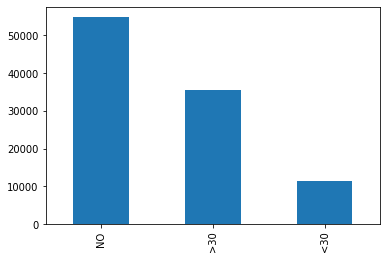

In [42]:
df_diabetic['readmitted'].value_counts().plot(kind='bar')

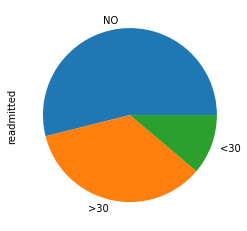

In [43]:
df_diabetic['readmitted'].value_counts().plot.pie()

### About the class objective
In general, is very unbalanced but if we consider ">30" and "<30" as one, the target can be quite balanced.

## Constructing an MVP model
As the first MVP let's encode some information about the past behaviour of the patients, the number of registries, visits, number of medicaments, number of past readmissions. For this, we can "shift" the target value and reuse them as features of the patient encounters, also use cumulated sums.

In [44]:
df_diabetic = df_diabetic.sort_values('encounter_id')

In [45]:
df_diabetic.describe().T

,count,mean,std,min,25%,50%,75%,max
age,"101,763.0",66.0,15.9,5.0,55.0,65.0,75.0,95.0
weight,"3,197.0",86.3,26.1,12.5,62.5,87.5,112.5,212.5
time_in_hospital,"101,763.0",4.4,3.0,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,"101,763.0",43.1,19.7,1.0,31.0,44.0,57.0,132.0
num_procedures,"101,763.0",1.3,1.7,0.0,0.0,1.0,2.0,6.0
num_medications,"101,763.0",16.0,8.1,1.0,10.0,15.0,20.0,81.0
number_outpatient,"101,763.0",0.4,1.3,0.0,0.0,0.0,0.0,42.0
number_emergency,"101,763.0",0.2,0.9,0.0,0.0,0.0,0.0,76.0
number_inpatient,"101,763.0",0.6,1.3,0.0,0.0,0.0,1.0,21.0
number_diagnoses,"101,763.0",7.4,1.9,1.0,6.0,8.0,9.0,16.0


### Feature engineering function

In [46]:
def feature_eng(df_):
    df_temp = pd.DataFrame(index=df_.index, columns=['age_mean', 'n_entry', 'cum_time_in_hospital', 'cum_cnt_meds',
       'cum_cnt_meds_change', 'number_inpatient_log', 'number_outpatient_log',
       'number_emergency_log', 'number_visits', 'number_visits_log',
       'number_inpatient_cumsum', 'number_outpatient_cumsum',
       'number_emergency_cumsum', 'number_visits_cumsum',
       'readmited_times_<30_past', 'readmited_times_>30_past',
       'readmited_times_NO_past', 'readmited_times_<30_past_ratio',
       'readmited_times_>30_past_ratio', 'readmited_times_NO_past_ratio'])

    df_temp['ones'] = 1
    
    # Store mean afe during all studies
    df_temp['age_mean'] = df_['age'].mean()
    
    # Number of registries (entries)
    df_temp['n_entry'] = df_temp['ones'].cumsum()

    # Cumualted time on hospital
    df_temp['cum_time_in_hospital'] = df_['time_in_hospital'].cumsum()
    
    # Count of medicaments and change of dosage
    df_temp['cum_cnt_meds'] = df_['cnt_meds'].cumsum()
    df_temp['cum_cnt_meds_change'] = df_['cnt_meds_change'].cumsum()

    # From pandas profiling histograms we can try to normalizate some skewed distrbutions
    df_temp['number_inpatient_log'] = np.log(df_['number_inpatient']+1)
    df_temp['number_outpatient_log'] = np.log(df_['number_outpatient']+1)
    df_temp['number_emergency_log'] = np.log(df_['number_emergency']+1)

    # Total of visits
    df_temp['number_visits'] = df_['number_inpatient']  + df_['number_outpatient'] + df_['number_emergency']
    df_temp['number_visits_log'] = np.log(df_temp['number_visits']+1)

    # Cumulated visits
    df_temp['number_inpatient_cumsum'] = df_temp['number_inpatient_log'].cumsum()
    df_temp['number_outpatient_cumsum'] = df_temp['number_outpatient_log'].cumsum()
    df_temp['number_emergency_cumsum'] = df_temp['number_emergency_log'].cumsum()
    df_temp['number_visits_cumsum'] = df_temp['number_visits_log'].cumsum()

    # readmited counters, value are shifted to avoid overfitting
    df_temp['readmited_times_<30_past'] = (df_['readmitted'].shift() == '<30').cumsum()
    df_temp['readmited_times_>30_past'] = (df_['readmitted'].shift() == '>30').cumsum()
    df_temp['readmited_times_NO_past'] = (df_['readmitted'].shift() == 'NO').cumsum()

    # ratio of readmited counters by registry
    df_temp['readmited_times_<30_past_ratio'] = df_temp['readmited_times_<30_past'] /df_temp['n_entry']
    df_temp['readmited_times_>30_past_ratio'] = df_temp['readmited_times_>30_past'] /df_temp['n_entry']   
    df_temp['readmited_times_NO_past_ratio'] = df_temp['readmited_times_NO_past'] /df_temp['n_entry']   

    return df_temp.drop(columns='ones')

### Parallel apply is better to create the new features

In [47]:
df_new_feng=df_diabetic.groupby(['patient_nbr']).parallel_apply(feature_eng)

In [49]:
df_diabetic_processed = pd.concat([df_diabetic,df_new_feng],axis=1)

In [50]:
pd.set_option('display.max_rows', 100)
df_ =df_diabetic_processed[
    df_diabetic_processed['patient_nbr']==(df_diabetic_processed[df_diabetic_processed['n_entry']>1]['patient_nbr'].sample(1).values[0])
]
df_.T

,5668,8574
encounter_id,29167980,38562012
patient_nbr,36179685,36179685
race,Caucasian,Caucasian
age,65,65
weight,NaN,NaN
admission_type_id,6,6
discharge_disposition_id,1,1
admission_source_id,17,17
time_in_hospital,7,6
payer_code,NaN,NaN


In [62]:
num_cols = df_diabetic_processed.describe().columns
df_diabetic_processed.describe()

,age,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,number_inpatient_cumsum,number_outpatient_cumsum,number_emergency_cumsum,number_visits_cumsum,readmited_times_<30_past,readmited_times_>30_past,readmited_times_NO_past,readmited_times_<30_past_ratio,readmited_times_>30_past_ratio,readmited_times_NO_past_ratio
count,"101,763.0","3,197.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0",...,"101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0","101,763.0"
mean,66.0,86.3,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4,...,0.7,0.3,0.3,1.1,0.2,0.4,0.0,0.0,0.1,0.0
std,15.9,26.1,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9,...,2.4,1.1,1.4,2.9,0.7,1.0,0.1,0.1,0.2,0.0
min,5.0,12.5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,55.0,62.5,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,65.0,87.5,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,75.0,112.5,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0,...,0.7,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0
max,95.0,212.5,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0,...,91.1,30.8,47.2,103.5,22.0,17.0,2.0,0.9,0.9,0.5


In [61]:
cat_cols = df_diabetic_processed.describe(include=[object,'category']).columns
df_diabetic_processed.describe(include=[object,'category'])

,encounter_id,patient_nbr,race,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,readmitted
count,101763,101763,99492,101763,101763,101763,61508,51816,101742,101405,100340,101763
unique,101763,71515,5,8,26,17,17,72,716,748,789,3
top,443867222,88785891,Caucasian,1,1,7,MC,InternalMedicine,428,276,250,NO
freq,1,40,76099,53988,60232,57492,32439,14635,6862,6752,11555,54861


In [57]:
df_diabetic_processed.dtypes

encounter_id                      category
patient_nbr                       category
race                                object
age                                  int64
weight                             float64
admission_type_id                 category
discharge_disposition_id          category
admission_source_id               category
time_in_hospital                     int64
payer_code                          object
medical_specialty                   object
num_lab_procedures                   int64
num_procedures                       int64
num_medications                      int64
number_outpatient                    int64
number_emergency                     int64
number_inpatient                     int64
diag_1                              object
diag_2                              object
diag_3                              object
number_diagnoses                     int64
max_glu_serum                      float64
A1Cresult                          float64
metformin  

### We have reduced several categorical features to numeric versions
The new variables can bring us multicollinearity problems, however there are algorithms that are not completely affected with multicollinearity such as random forests. However, we must bear in mind that it can have an effect on the interpretation of the importance of variables.

In [64]:
cat_cols

Index(['encounter_id', 'patient_nbr', 'race', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'readmitted'],
      dtype='object')

In [8]:
ignore_features = ['encounter_id', 'patient_nbr']

numeric_features=['age', 'weight', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'cnt_meds_change', 'cnt_meds',
       'metformin_change', 'repaglinide_change', 'nateglinide_change',
       'chlorpropamide_change', 'glimepiride_change', 'glipizide_change',
       'glyburide_change', 'pioglitazone_change', 'rosiglitazone_change',
       'acarbose_change', 'miglitol_change', 'tolazamide_change',
       'insulin_change', 'glyburide-metformin_change', 'gender_Male',
       'change_No', 'diabetesMed_Yes', 'age_mean', 'n_entry',
       'cum_time_in_hospital', 'cum_cnt_meds', 'cum_cnt_meds_change',
       'number_inpatient_log', 'number_outpatient_log', 'number_emergency_log',
       'number_visits', 'number_visits_log', 'number_inpatient_cumsum',
       'number_outpatient_cumsum', 'number_emergency_cumsum',
       'number_visits_cumsum', 'readmited_times_<30_past',
       'readmited_times_>30_past', 'readmited_times_NO_past',
       'readmited_times_<30_past_ratio', 'readmited_times_>30_past_ratio',
       'readmited_times_NO_past_ratio']

categorical_features = ['race', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3']

target_feature=['readmitted']

len(ignore_features+numeric_features+categorical_features+target_feature), df_diabetic_processed.shape

(84, (101763, 84))

In [68]:
df_diabetic_processed = df_diabetic_processed[ignore_features+numeric_features+categorical_features+target_feature]

### Save Pre-processing

In [69]:
# Save RAW
df_diabetic_processed.to_parquet('diabetic_processed.parquet')

In [4]:
ls -ltr -h

total 38M
-rw-rw-r-- 1 david david  19M may 15  2014 diabetic_data.csv
-rw-rw-r-- 1 david david 2,5K may 15  2014 IDs_mapping.csv
-rw-rw-r-- 1 david david 1,5M sep 21  2019 description.pdf
-rw-rw-r-- 1 david david  176 oct  3 18:36 README.md
-rw-rw-r-- 1 david david  13M oct  3 18:45 diabetic_report.html
-rw-rw-r-- 1 david david 4,3M oct  3 18:58 diabetic_processed.parquet
-rw-rw-r-- 1 david david 206K oct  3 19:02 David_Torres.ipynb


## EDA

### We already have a more comfortable database to explore and build a simple model
The new database is composed by 84 features, some of them still categorical

In [5]:
df_diabetic_processed = pd.read_parquet('diabetic_processed.parquet')
df_diabetic_processed.shape

(101763, 84)

In [6]:
df_diabetic_processed[df_diabetic_processed['patient_nbr']==89453052].T

,42549,43151,65315,74024,79192,83833,99183,99712
encounter_id,131167752,133260408,182001558,219927366,242836476,263124606,410270696,416680166
patient_nbr,89453052,89453052,89453052,89453052,89453052,89453052,89453052,89453052
age,55,55,55,65,65,65,65,65
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_in_hospital,12,7,11,6,5,6,4,5
...,...,...,...,...,...,...,...,...
medical_specialty,Pulmonology,Emergency/Trauma,Pulmonology,Emergency/Trauma,Emergency/Trauma,Emergency/Trauma,Surgery-Vascular,Emergency/Trauma
diag_1,493,560,415,493,493,493,682,493
diag_2,427,428,453,428,459,428,884,278
diag_3,V58,493,428,401,250,786,E849,250


In [9]:
df_diabetic_processed[categorical_features].nunique().sort_values(ascending=False).head(10)

diag_3                      789
diag_2                      748
diag_1                      716
medical_specialty            72
discharge_disposition_id     26
payer_code                   17
admission_source_id          17
admission_type_id             8
race                          5
dtype: int64

### Let's delete high cardinality columns by now


We will recover this when the NN model is contructed.

Spoiler: Embeding layers will be used with them

In [37]:
df_mvp_model = df_diabetic_processed.copy(deep=True)

In [38]:
drop_columns = ['diag_3','diag_2','diag_1']+ignore_features

In [39]:
categorical_features_dp = df_mvp_model.columns[
       df_mvp_model.columns.isin(categorical_features)
&  ~df_mvp_model.columns.isin(drop_columns)]

df_mvp_model = df_mvp_model.drop(columns=drop_columns)
df_mvp_model.shape

(101763, 79)

In [40]:
categorical_features_dp

Index(['race', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'payer_code', 'medical_specialty'],
      dtype='object')

### One hot encoder for categorical variables

In [41]:
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(df_mvp_model[categorical_features_dp].fillna('Null')).toarray()
feature_cols = ohe.get_feature_names(categorical_features_dp)
feature_arr.shape, feature_cols.size

((101763, 148), 148)

In [42]:
df_mvp_model = pd.concat([pd.DataFrame(feature_arr, columns=feature_cols, index=df_mvp_model.index),
                      df_mvp_model.drop(columns=categorical_features_dp)],
                     axis=1)

df_mvp_model = pd.concat([df_mvp_model,
                      pd.get_dummies(df_mvp_model['readmitted'])],
                     axis=1)

df_mvp_model.shape

(101763, 224)

In [43]:
df_mvp_model.columns

Index(['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Null', 'race_Other', 'admission_type_id_1', 'admission_type_id_2',
       'admission_type_id_3', 'admission_type_id_4',
       ...
       'readmited_times_<30_past', 'readmited_times_>30_past',
       'readmited_times_NO_past', 'readmited_times_<30_past_ratio',
       'readmited_times_>30_past_ratio', 'readmited_times_NO_past_ratio',
       'readmitted', '<30', '>30', 'NO'],
      dtype='object', length=224)

### EDA, exploration of correlationnwith target variables

In [44]:
df_corr = df_mvp_model.corr()[['<30', '>30', 'NO']]
df_corr = df_corr.sort_values(by='NO', ascending=False)

<ipython-input-45-d56183625741>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr[~(df_corr[['<30', '>30', 'NO']]==1).any(axis=1)][df_corr['NO'].apply(np.abs)>0.025].plot(kind='barh', figsize=(7,20))


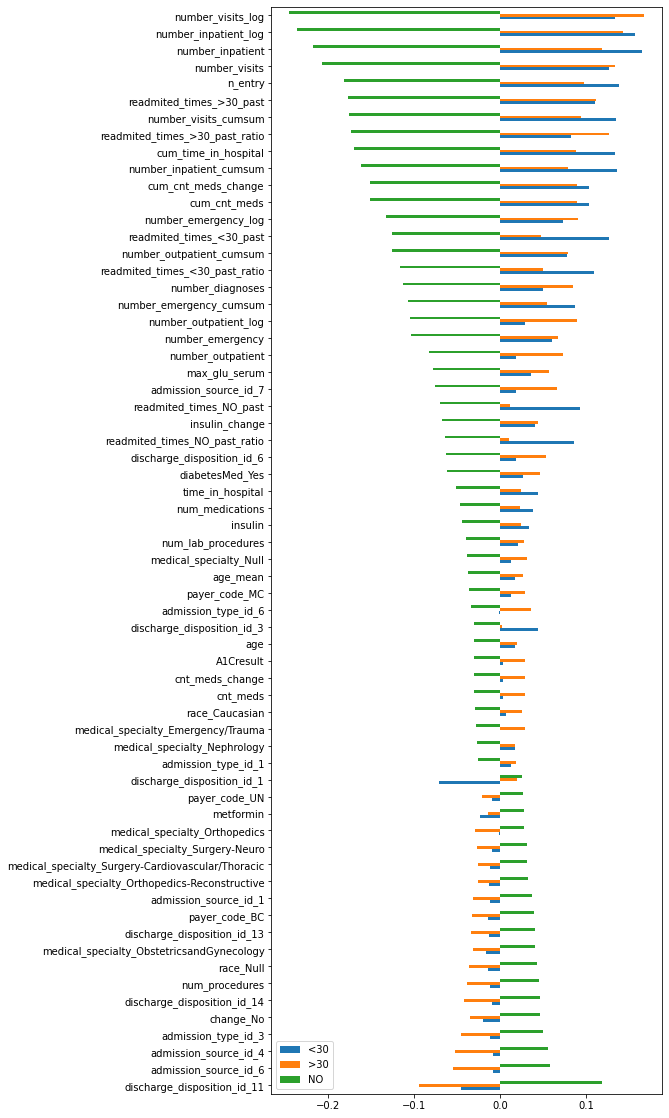

In [45]:
df_corr[~(df_corr[['<30', '>30', 'NO']]==1).any(axis=1)][df_corr['NO'].apply(np.abs)>0.025].plot(kind='barh', figsize=(7,20))

### First insights

The number of visits, a number of readmitted events, count of medications, total time in the hospital seems to be correlated with chances of being readmitted.

And, for no-readmitted cases, we have interesting variables correlated as the deceased patients (discharge disposition 11) someyhing obvious since the patient will not be able to be readmitted.

### Encoding target label

In [46]:
df_mvp_model['readmitted_label'] = LabelEncoder().fit_transform(df_mvp_model['readmitted'])

In [47]:
df_mvp_model['readmitted_label'].value_counts()

2    54861
1    35545
0    11357
Name: readmitted_label, dtype: int64

In [48]:
df_mvp_model.to_parquet('diabetic_data_mvp_model.parquet')
df_mvp_model.shape

(101763, 225)

In [49]:
ls -ltr -h

total 41M
-rw-rw-r-- 1 david david  19M may 15  2014 diabetic_data.csv
-rw-rw-r-- 1 david david 2,5K may 15  2014 IDs_mapping.csv
-rw-rw-r-- 1 david david 1,5M sep 21  2019 description.pdf
-rw-rw-r-- 1 david david  176 oct  3 18:36 README.md
-rw-rw-r-- 1 david david  13M oct  3 18:45 diabetic_report.html
-rw-rw-r-- 1 david david 4,3M oct  3 18:58 diabetic_processed.parquet
-rw-rw-r-- 1 david david 323K oct  3 19:25 David_Torres.ipynb
-rw-rw-r-- 1 david david 2,9M oct  3 19:25 diabetic_data_mvp_model.parquet


In [50]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/home/david/Escritorio/ds4a/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Modeling MVP

In [52]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


In [136]:
df_model = pd.read_parquet('diabetic_data_mvp_model.parquet').fillna(0)

In [22]:
df_model.shape

(101763, 225)

SMOTE library to avoid unbalanced classes

In [85]:
from imblearn.over_sampling import SMOTE

balanced = True

X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,:-5], df_model.iloc[:,-2], test_size=0.10, random_state = 42)

if ~balanced:
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.10)
else:
    smt = SMOTE()
    X_train_smote, y_train_smote = smt.fit_sample(X_train, y_train)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_smote, y_train_smote, test_size=0.10, random_state=0)

X_train.shape, X_test.shape, X_dev.shape

((82427, 220), (10177, 220), (9159, 220))

In [86]:
df_model.iloc[:,-5:]

,readmitted,<30,>30,NO,readmitted_label
8,NO,0,0,1,2
9,NO,0,0,1,2
4,NO,0,0,1,2
10,>30,0,1,0,1
5,>30,0,1,0,1
...,...,...,...,...,...
101761,>30,0,1,0,1
101762,NO,0,0,1,2
101763,NO,0,0,1,2
101764,NO,0,0,1,2


### Desicion Tree

In [87]:
from sklearn.tree import DecisionTreeClassifier

In [88]:
model_DT = DecisionTreeClassifier(max_depth=20, criterion = "entropy", min_samples_split=10)

In [89]:
cv_score = cross_val_score(model_DT, X_train, y_train, cv=5)
cv_score.mean(), cv_score.std()

(0.6111346622501658, 0.002958090584256729)

In [90]:
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10)

In [91]:
model_DT.score(X_dev, y_dev)

0.6152418386286712

In [92]:
confusion_matrix(y_dev, y_dev_predict)

array([[1620, 2636],
       [1838, 3065]])

In [93]:
y_dev_predict = model_DT.predict(X_dev)
print("Accuracy {0:.3f}".format(accuracy_score(y_dev, y_dev_predict)))
print("Precision {0:.3f}".format(precision_score(y_dev, y_dev_predict)))
print("Recall {0:.3f}".format(recall_score(y_dev, y_dev_predict)))
print("AUC {0:.3f}".format(roc_auc_score(y_dev, y_dev_predict)))

Accuracy 0.615
Precision 0.637
Recall 0.653
AUC 0.612


In [94]:
confusion_matrix(y_test, y_test_predict)

array([[1721, 2951],
       [2074, 3431]])

In [95]:
y_test_predict = model_DT.predict(X_test)
print("Accuracy {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))

Accuracy 0.615
Precision 0.641
Recall 0.654
AUC 0.611


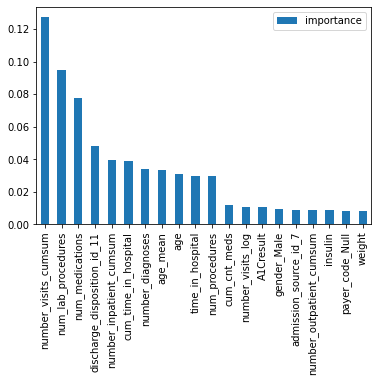

In [96]:
df_importance = pd.DataFrame(model_DT.feature_importances_,
                             index=X_train.columns,
                             columns=['importance']).sort_values('importance', ascending=False).head(20)
df_importance.plot(kind='bar')

Accuracy is near to 62% that is not quite good,
Let's highlight that recall is higher than precision, which indicates that our false negative rate is low compared to the false positive rate.

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [102]:
rf = RandomForestClassifier()

In [115]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [100, 250],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [ 5, 10],
 'n_estimators': [250, 500]}

In [100]:
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 150,
                               cv = 3,
                               verbose=2,
                               n_jobs = -1)

In [103]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/home/david/Escritorio/ds4a/py3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 64 is smaller than n_iter=150. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.9min
/home/david/Escritorio/ds4a/py3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 39.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=150,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100, 250],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [250, 500]},
                   verbose=2)

In [105]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=250)

In [113]:
# Save model
joblib.dump(rf_random, 'rf_random.pkl')

['rf_random.pkl']

In [59]:
rf_random = joblib.load('rf_random.pkl')

In [116]:
rf_random.score(X_dev, y_dev)

0.658696364231903

In [117]:
y_dev_predict = rf_random.predict(X_dev)

In [118]:
print("Accuracy {0:.3f}".format(accuracy_score(y_dev, y_dev_predict)))
print("Precision {0:.3f}".format(precision_score(y_dev, y_dev_predict)))
print("Recall {0:.3f}".format(recall_score(y_dev, y_dev_predict)))
print("AUC {0:.3f}".format(roc_auc_score(y_dev, y_dev_predict)))
confusion_matrix(y_dev, y_dev_predict)

Accuracy 0.659
Precision 0.657
Recall 0.760
AUC 0.651


array([[2308, 1948],
       [1178, 3725]])

In [119]:
y_test_predict = rf_random.predict(X_test)

In [120]:
print("Accuracy {0:.3f}".format(accuracy_score(y_test, y_test_predict)))
print("Precision {0:.3f}".format(precision_score(y_test, y_test_predict)))
print("Recall {0:.3f}".format(recall_score(y_test, y_test_predict)))
print("AUC {0:.3f}".format(roc_auc_score(y_test, y_test_predict)))
confusion_matrix(y_test, y_test_predict)

Accuracy 0.656
Precision 0.659
Recall 0.751
AUC 0.647


array([[2537, 2135],
       [1370, 4135]])

In [121]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=250)

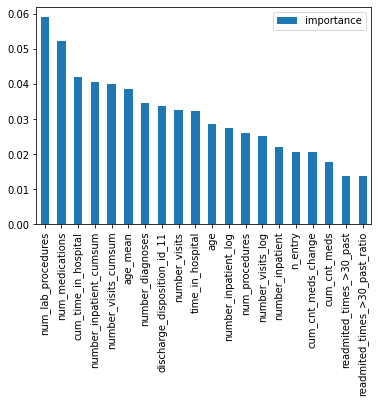

In [122]:
df_importance = pd.DataFrame(rf_random.best_estimator_.feature_importances_,
                             index=X_train.columns,
                             columns=['importance']).sort_values('importance', ascending=False).head(20)
df_importance.plot(kind='bar')

Random forests have a better response, however the overall accuracy remains very low 65%. Likewise, recall is still greater than the precision, as we saw in the case of decision trees; well significantly better 75%!

### Pycaret for more fast MVPs
Pycaret is an automated machine learning library that allows a quick approach to various models, after a basic exploration I leave lightgbm (gradient boosting model) as an example of use.

In [124]:
from pycaret.classification import *

In [125]:
new_columns = []
for i in df_model.columns:
    new_columns = new_columns +[i.replace('<','less_').replace('>','greater_')]
df_model.columns = new_columns

In [121]:
#readmitted_label
clf1 = setup(data = df_model[df_model.columns[:-5].to_list() + ['readmitted_label']],
                  target = 'readmitted_label',
                  numeric_features=df_model.columns[:-5])

Setup Succesfully Completed!


,Description,Value
0,session_id,1721
1,Target Type,Multiclass
2,Label Encoded,"0: 0, 1: 1, 2: 2"
3,Original Data,"(101763, 221)"
4,Missing Values,False
5,Numeric Features,220
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [126]:
lgbm = create_model('lightgbm')      

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5969,0.0000,0.4275,0.5675,0.5535,0.2182,0.2336
1,0.6088,0.0000,0.4427,0.5914,0.5693,0.2462,0.2604
2,0.6028,0.0000,0.4301,0.5679,0.5587,0.2311,0.2464
3,0.5970,0.0000,0.4288,0.5686,0.5553,0.2218,0.2355
4,0.6102,0.0000,0.4423,0.5844,0.5696,0.2480,0.2634
5,0.6053,0.0000,0.4397,0.5838,0.5664,0.2407,0.2539
6,0.6064,0.0000,0.4427,0.5976,0.5667,0.2394,0.2548
7,0.6088,0.0000,0.4401,0.5817,0.5678,0.2449,0.2601
8,0.6103,0.0000,0.4412,0.5846,0.5693,0.2478,0.2631
9,0.6031,0.0000,0.4358,0.5796,0.5620,0.2331,0.2478


In [127]:
tuned_lightgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5990,0.0000,0.4299,0.5740,0.5560,0.2225,0.2380
1,0.6061,0.0000,0.4380,0.5868,0.5647,0.2384,0.2537
2,0.6002,0.0000,0.4280,0.5666,0.5559,0.2253,0.2406
3,0.6007,0.0000,0.4303,0.5669,0.5582,0.2286,0.2428
4,0.6142,0.0000,0.4440,0.5892,0.5727,0.2550,0.2709
5,0.6055,0.0000,0.4391,0.5822,0.5662,0.2406,0.2540
6,0.5995,0.0000,0.4336,0.5817,0.5580,0.2247,0.2399
7,0.6134,0.0000,0.4443,0.5921,0.5727,0.2540,0.2693
8,0.6115,0.0000,0.4413,0.5895,0.5692,0.2475,0.2643
9,0.6046,0.0000,0.4364,0.5805,0.5632,0.2355,0.2506


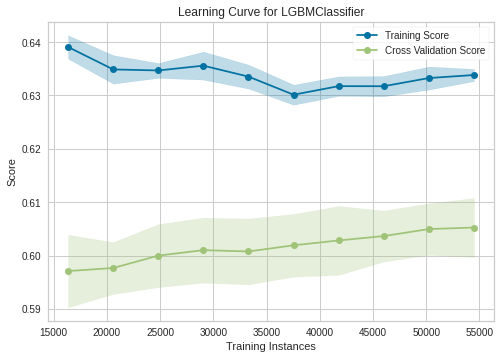

In [128]:
plot_model(estimator = tuned_lightgbm, plot = 'learning')

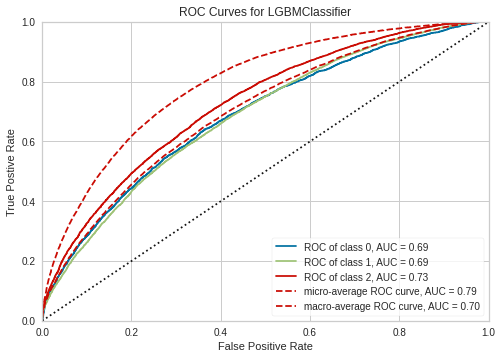

In [129]:
plot_model(estimator = tuned_lightgbm, plot = 'auc')

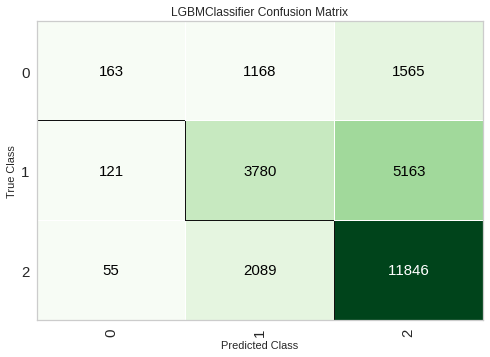

In [130]:
plot_model(estimator = tuned_lightgbm, plot = 'confusion_matrix')

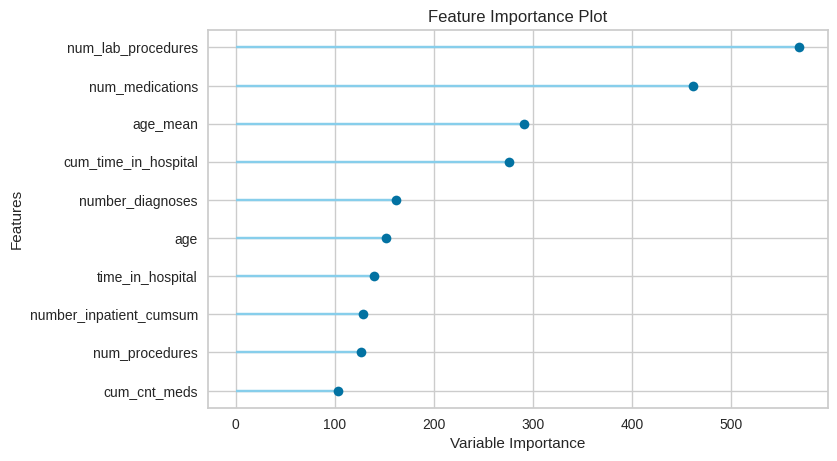

In [131]:
plot_model(estimator = tuned_lightgbm, plot = 'feature')

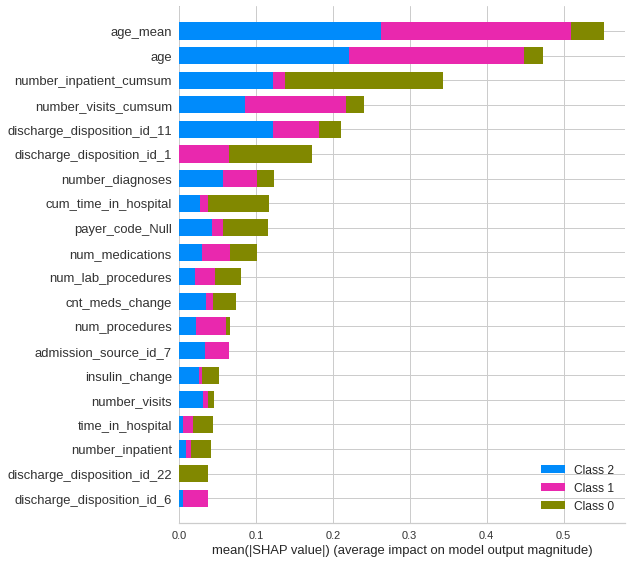

In [145]:
interpretation = interpret_model(tuned_lightgbm)

In this case, an attempt was made to predict the 3 classes, no type of balancing was used, the accuracy is still low woth high rates of false positives and negatives.

# Unsupervised
A unsupervised exploration may allow us to understand if there is a relationship between automated clusters and the target variable

In [139]:
X = df_model.iloc[:,:-5]
Y = df_model.iloc[:,-1]

In [140]:
Y.value_counts()

2    54861
1    35545
0    11357
Name: readmitted_label, dtype: int64

In [141]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import time

In [98]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 101763 samples in 18.282s...
[t-SNE] Computed neighbors for 101763 samples in 540.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 101763
[t-SNE] Computed conditional probabilities for sample 2000 / 101763
[t-SNE] Computed conditional probabilities for sample 3000 / 101763
[t-SNE] Computed conditional probabilities for sample 4000 / 101763
[t-SNE] Computed conditional probabilities for sample 5000 / 101763
[t-SNE] Computed conditional probabilities for sample 6000 / 101763
[t-SNE] Computed conditional probabilities for sample 7000 / 101763
[t-SNE] Computed conditional probabilities for sample 8000 / 101763
[t-SNE] Computed conditional probabilities for sample 9000 / 101763
[t-SNE] Computed conditional probabilities for sample 10000 / 101763
[t-SNE] Computed conditional probabilities for sample 11000 / 101763
[t-SNE] Computed conditional probabilities for sample 12000 / 101763
[t-SNE] Computed conditional pro

In [103]:
df_tsne = pd.DataFrame(tsne_results, columns=['x1','x2'], index=df_model.index)
df_tsne.to_parquet('tsne_results.parquet')

In [131]:
df_tsne = pd.read_parquet('tsne_results.parquet')

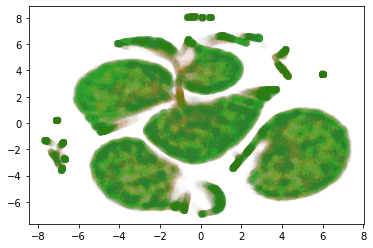

In [132]:
# create scatter plot for samples from each cluster
for cluster in range(3):
    # create scatter of these samples
    plt.scatter(df_tsne.loc[Y == cluster, 'x1'], df_tsne.loc[Y == cluster, 'x2'], alpha=0.01)
    # show the plot
plt.show()

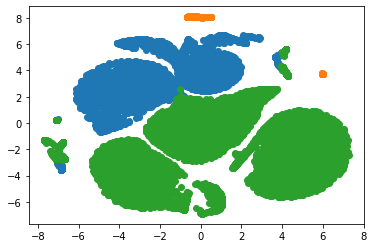

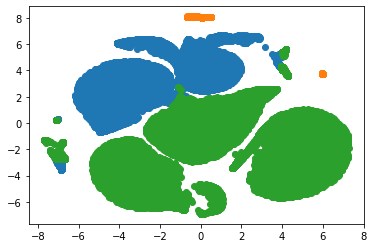

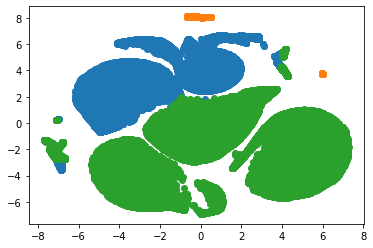

In [142]:
from sklearn.cluster import KMeans
# define the model
model = KMeans(n_clusters=3)
# fit the model
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for i in range(3):
    plt.figure()
    idx_tsne = (Y==i)
    for cluster in clusters:
        # create scatter of these samples
        plt.scatter(df_tsne.loc[(yhat == cluster) & idx_tsne, 'x1'], df_tsne.loc[(yhat == cluster) & idx_tsne, 'x2'])
    # show the plot
plt.show()

In [143]:
df_model['kmeans'] = yhat

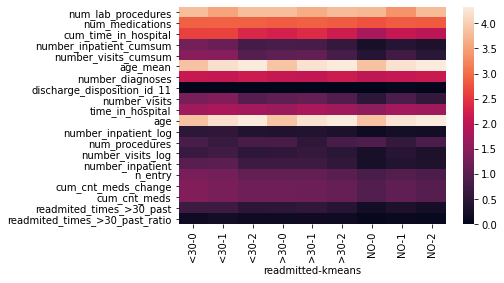

In [144]:
import seaborn as sns
sns.heatmap(df_model.groupby(['readmitted','kmeans'])[df_importance.index].mean().apply(lambda x: np.log(x+1)).T)

I do not find any interesting pattern between the groups, the important variables and the target variable; let's continue with a more fun model, neural networks

# Neuronal Networks

In the case of neural networks we use all the categorical variables, and we will use an emebedding layer for them.

In [113]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [114]:
df_model = pd.read_parquet('diabetic_processed.parquet')
df_model = pd.concat([df_model,
                      pd.get_dummies(df_model['readmitted'])],
                     axis=1)
df_model.shape

(101763, 87)

In [115]:
df_model.describe().columns

Index(['encounter_id', 'patient_nbr', 'age', 'weight', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'cnt_meds_change', 'cnt_meds',
       'metformin_change', 'repaglinide_change', 'nateglinide_change',
       'chlorpropamide_change', 'glimepiride_change', 'glipizide_change',
       'glyburide_change', 'pioglitazone_change', 'rosiglitazone_change',
       'acarbose_change', 'miglitol_change', 'tolazamide_change',
       'insulin_c

In [116]:
df_model.columns[~df_model.columns.isin(df_model.describe().columns)]

Index(['race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
       'readmitted'],
      dtype='object')

### All variables can be considered

In [117]:
ignore_features = ['encounter_id', 'patient_nbr']

numeric_features = ['age', 'weight', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'cnt_meds_change', 'cnt_meds',
       'metformin_change', 'repaglinide_change', 'nateglinide_change',
       'chlorpropamide_change', 'glimepiride_change', 'glipizide_change',
       'glyburide_change', 'pioglitazone_change', 'rosiglitazone_change',
       'acarbose_change', 'miglitol_change', 'tolazamide_change',
       'insulin_change', 'glyburide-metformin_change', 'gender_Male',
       'change_No', 'diabetesMed_Yes', 'age_mean', 'n_entry',
       'cum_time_in_hospital', 'cum_cnt_meds', 'cum_cnt_meds_change',
       'number_inpatient_log', 'number_outpatient_log', 'number_emergency_log',
       'number_visits', 'number_visits_log', 'number_inpatient_cumsum',
       'number_outpatient_cumsum', 'number_emergency_cumsum',
       'number_visits_cumsum', 'readmited_times_<30_past',
       'readmited_times_>30_past', 'readmited_times_NO_past',
       'readmited_times_<30_past_ratio', 'readmited_times_>30_past_ratio',
       'readmited_times_NO_past_ratio']

categorical_features = ['race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
                                 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']

target_feature=['readmitted','<30', '>30', 'NO']

len(ignore_features+numeric_features+categorical_features+target_feature)

87

In [118]:
df_model = df_model[numeric_features+categorical_features+target_feature]
df_model.shape

(101763, 85)

In [119]:
for i in tqdm(categorical_features):
    df_model[i] = LabelEncoder().fit_transform(df_model[i].fillna('Null'))

100%|██████████| 9/9 [00:00<00:00, 87.34it/s]


In [120]:
#df_model = df_model.drop(columns=['readmitted'])
df_model = df_model.fillna(0)

### Tesnorflow is used to construct the model

In [121]:
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [122]:
df_model[categorical_features].nunique()

race                          6
payer_code                   18
medical_specialty            73
diag_1                      717
diag_2                      749
diag_3                      790
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
dtype: int64

In [123]:
df_model

,age,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,diag_1,diag_2,diag_3,admission_type_id,discharge_disposition_id,admission_source_id,readmitted,<30,>30,NO
8,85,0.0,13,68,2,28,0,0,0,8,...,252,260,229,1,0,3,NO,0,0,1
9,95,0.0,12,33,3,18,0,0,0,8,...,282,46,317,2,2,3,NO,0,0,1
4,45,0.0,1,51,0,8,0,0,0,5,...,54,24,86,0,0,6,NO,0,0,1
10,45,0.0,9,47,2,17,0,0,0,9,...,120,241,666,0,0,6,>30,0,1,0
5,55,0.0,3,31,6,16,0,0,0,9,...,263,246,86,1,0,1,>30,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,75,0.0,3,51,0,16,0,0,0,9,...,102,148,295,0,2,6,>30,0,1,0
101762,85,0.0,5,33,3,18,0,0,1,9,...,381,133,536,0,3,4,NO,0,0,1
101763,75,0.0,1,53,0,9,1,0,0,13,...,236,389,159,0,0,6,NO,0,0,1
101764,85,0.0,10,45,2,21,0,0,1,9,...,693,142,668,1,2,6,NO,0,0,1


In [138]:
X, y = df_model.fillna(0).iloc[:,:-4], df_model.iloc[:,-4:],

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10)
X_train.shape , X_val.shape , X_test.shape, y_train.shape , y_val .shape , y_test.shape 

((87006, 81), (9668, 81), (5089, 81), (87006, 4), (9668, 4), (5089, 4))

In [149]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

X = df_model.fillna(0).iloc[:,:-4]
X_smote, y_smote = smt.fit_sample(X, df_model['readmitted'])
y_smote = pd.concat([y_smote,pd.get_dummies(y_smote)],axis=1)

X_smote.shape, y_smote.shape

((164583, 81), (164583, 4))

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size=0.05)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05)
X_train.shape , X_val.shape , X_test.shape, y_train.shape , y_val .shape , y_test.shape 

((120231, 81), (6328, 81), (6662, 81), (120231, 4), (6328, 4), (6662, 4))

In [152]:
# Numericals
num_variables = len(numeric_features)
X_train.columns[:num_variables]

Index(['age', 'weight', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'cnt_meds_change', 'cnt_meds',
       'metformin_change', 'repaglinide_change', 'nateglinide_change',
       'chlorpropamide_change', 'glimepiride_change', 'glipizide_change',
       'glyburide_change', 'pioglitazone_change', 'rosiglitazone_change',
       'acarbose_change', 'miglitol_change', 'tolazamide_change',
       'insulin_change', 'glyburide-metformin_ch

In [153]:
input_length = X_train.shape[1]
num_categorical = input_length-num_variables
num_categorical

9

In [154]:
def max_cat(col_name):
    max_ = df_model[col_name].max()+1
    return int(max_), int(1.6*(max_**.56))

### Embedding layer for categorical variables is implemented side by side with layers for numerical, dropout is used for regularization

In [155]:
cat_inputs = []
concat_emb_layer = []

num_input = keras.Input(shape=(1, num_variables), name='numeric')

num_layer = layers.Dense(64, 'relu', name='numeric_layer')(num_input)
num_layer = layers.Dropout(0.05)(num_layer)
num_layer = layers.Dense(32, 'relu', name='numeric_layer')(num_input)
num_layer = layers.Dropout(0.05)(num_layer)

for i in range(len(categorical_features)):
    _input = keras.Input(shape=(1,), name='cat_'+categorical_features[i])
    _embed = layers.Embedding(max_cat(categorical_features[i])[0], max_cat(categorical_features[i])[1],
                              name='emb_'+categorical_features[i])(_input)
    print(categorical_features[i], max_cat(categorical_features[i]))

    cat_inputs.append(_input)
    concat_emb_layer.append(_embed)


emb_layer = layers.concatenate(concat_emb_layer)
emb_layer = layers.Dropout(0.05)(emb_layer)

emb_layer = layers.Dense(64, activation='linear')(emb_layer)
emb_layer = layers.Dropout(0.05)(emb_layer)
emb_layer = layers.Dense(32, activation='relu')(emb_layer)
emb_layer = layers.Dropout(0.25)(emb_layer)
emb_layer = layers.Dense(16, activation='relu')(emb_layer)
emb_layer = layers.Dropout(0.25)(emb_layer)

x = layers.concatenate([num_layer, emb_layer])
x = layers.Dense(32, 'relu', name='layer_1')(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(16, 'relu', name='layer_2')(x)
x = layers.Dropout(0.25)(x)

output = layers.Dense(3, activation='softmax', name='predict')(x)

race (6, 4)
payer_code (18, 8)
medical_specialty (73, 17)
diag_1 (717, 63)
diag_2 (749, 65)
diag_3 (790, 67)
admission_type_id (8, 5)
discharge_disposition_id (26, 9)
admission_source_id (17, 7)


In [156]:
model = keras.Model([num_input]+cat_inputs, output)

### The model have two sub netwroks concatenated, the numerical and the categorical.

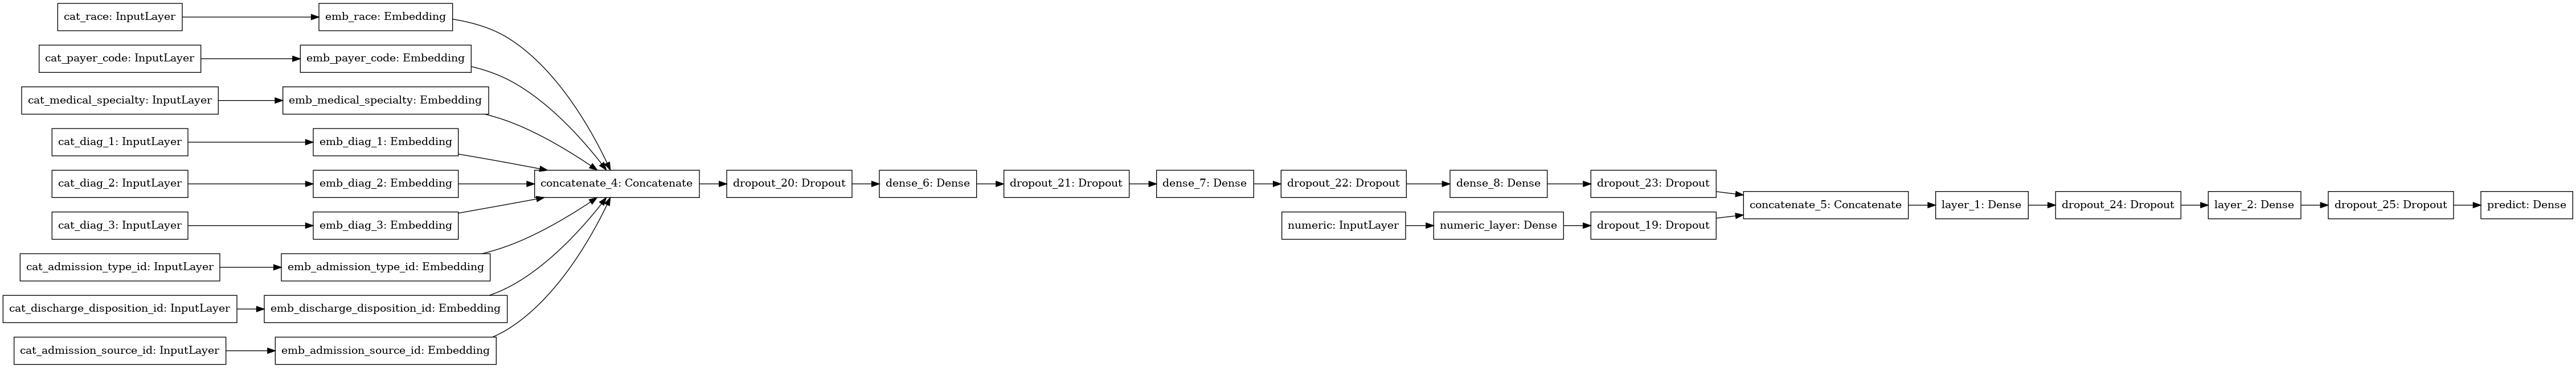

In [157]:
keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [158]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [159]:
def format_dataset(df):
    X = [df.iloc[:,:num_variables].fillna(0).astype('float32').values.reshape(-1,1,num_variables)]
    for i in categorical_features:
        X.append(df[i].astype('float32').values)
    return X

In [160]:
history = model.fit(format_dataset(X_train), y_train.iloc[:,1:].values.reshape(-1,1,3),
    validation_data=(format_dataset(X_val), y_val.iloc[:,1:].values.reshape(-1,1,3)),
                    batch_size=64,
                    epochs=100)

Epoch 1/100
1879/1879 [==============================] - 3s 2ms/step - loss: 1.0152 - accuracy: 0.4686 - val_loss: 0.8812 - val_accuracy: 0.5626
Epoch 2/100
1879/1879 [==============================] - 3s 2ms/step - loss: 0.8826 - accuracy: 0.5671 - val_loss: 0.8459 - val_accuracy: 0.5898
Epoch 3/100
1879/1879 [==============================] - 3s 2ms/step - loss: 0.8507 - accuracy: 0.5883 - val_loss: 0.8306 - val_accuracy: 0.6054
Epoch 4/100
1879/1879 [==============================] - 3s 2ms/step - loss: 0.8307 - accuracy: 0.5999 - val_loss: 0.8287 - val_accuracy: 0.6064
Epoch 5/100
1879/1879 [==============================] - 3s 2ms/step - loss: 0.8199 - accuracy: 0.6052 - val_loss: 0.8122 - val_accuracy: 0.6098
Epoch 6/100
1879/1879 [==============================] - 3s 2ms/step - loss: 0.8121 - accuracy: 0.6085 - val_loss: 0.8151 - val_accuracy: 0.6116
Epoch 7/100
1879/1879 [==============================] - 3s 2ms/step - loss: 0.8062 - accuracy: 0.6100 - val_loss: 0.8148 - val_ac

In [161]:
 model.evaluate(format_dataset(X_train), y_train.iloc[:,1:].values.reshape(-1,1,3))

3758/3758 [==============================] - 6s 2ms/step - loss: 0.6801 - accuracy: 0.6687


[0.6800599098205566, 0.6686628460884094]

In [162]:
print("Evaluate on test data")
results = model.evaluate(format_dataset(X_test), y_test.iloc[:,1:].values.reshape(-1,1,3))
print("test loss, test acc:", results)

Evaluate on test data
209/209 [==============================] - 0s 638us/step - loss: 0.8338 - accuracy: 0.6280
test loss, test acc: [0.833836019039154, 0.6280395984649658]


In [163]:
y_pred = model.predict(format_dataset(X_test)).reshape(X_test.shape[0],3)
y_pred_label = y_pred.argmax(axis=1)

In [164]:
y_test_label = y_test.iloc[:,1:].values.argmax(axis=1)

In [165]:
y_test.iloc[:,1:].sum()

<30    2273
>30    2130
NO     2259
dtype: int64

In [166]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

confusion_matrix(y_test_label, y_pred_label)

array([[1708,  250,  315],
       [ 702,  623,  805],
       [  48,  358, 1853]])

In [167]:
confusion_matrix(y_test_label, y_pred_label).sum(axis=1)

array([2273, 2130, 2259])

In [168]:
confusion_matrix(y_test_label, y_pred_label).sum(axis=0)

array([2458, 1231, 2973])

Text(33.0, 0.5, 'pred')

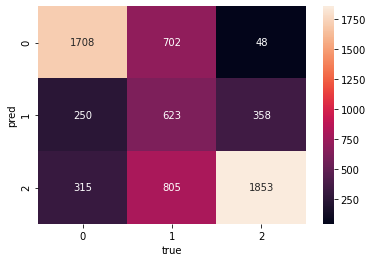

In [169]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_pred_label, y_test_label), annot=True, fmt="d")
plt.xlabel('true')
plt.ylabel('pred')

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Conclusion

I liked working with a database with high cardinality of categorical variables, although my first results did not lead to very high models, I set the goal of demonstrating my use and knowledge of various machine learning models, as well as database processing skills.

Although I could not spend much time, I would have liked more time to analyze the columns in detail, in order to create a better feature engienering, I consider that this procedure considerably increases the accuracy rates.

The models in general are simple to implement the hard work is on processing and exploring data from a business perspective, here supervised analytics become more important.